# Model Experimentation 6: Modified WaldoNet/Custom Head

In this next iteration, we use the aforementioned custom Waldo head along with the new modified WaldoNet architecture.

Previously I used a frozen pretrained WaldoNet as the size of the input images would cause my GPU to run out of memory. However, after a ton of trial and error, I found out that this was insufficient. So, I modified the WaldoNet architecture to produce even more aggressively reduced features (hoping that it would still be good enough):

| Type          | Filters | Size/Stride |
|---------------|---------|-------------|
| Convolutional | 64      | 3x3/1       |
| MaxPool       |         | 2x2/2       |
| Convolutional | 128     | 3x3/2       |
| MaxPool       |         | 2x2/2       |
| Convolutional | 256     | 3x3/2       |
| Convolutional | 128     | 1x1/1       |
| Convolutional | 256     | 3x3/2       |
| MaxPool       |         | 2x2/2       |
| Convolutional | 512     | 3x3/2       |
| Convolutional | 256     | 1x1/1       |
| Convolutional | 512     | 3x3/2       |
|---------------|---------|-------------|
| Convolutional | 500     | 1x1/1       |
| AvgPool       |         | Global      |

To my delight, it was. I trained from scratch the WaldoNet with the custom head and it worked... sort of. In the end, I found that the *Where's Waldo* problem is almost uniquely difficult in the world of object detection as each map is wildly different is style and size from any other map. Thus, it was essentially impossible for the model to generalize what waldo looked like and where in the map it could be found. As such, I had to "overfit" the model to recognize what each map looked like and had to give it some prior knowledge about where Waldo would be in the map. From this, after many hundreds of epochs of training, I was able to train the model to about 75% mIoU which it turns out performs fairly well on all the Waldo maps in the dataset.

In [1]:
import IPython.core.display as di
from IPython.display import Markdown as md

def toggle_code():
    di.display_html(
        """<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">
            Toggle code
        </button>""",
        raw=True,
    )
    
def md_cat(file_path):
    with open(file_path) as file:
        return md(f"```python\n{file.read()}\n```")

toggle_code()

Toggle code

In [2]:
import json
import os
import sys
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as torchv
from cached_property import cached_property
from matplotlib import patches
from PIL import Image
from tqdm.notebook import tqdm, trange

In [3]:
data_path = "../data"
sys.path.append(data_path)

In [4]:
from Dataset import Dataset, TestDataset, originals, boxes
from LossAccumulator import LossAccumulator
from Parameters import Parameters
from PolyLearningRateDecay import PolyLearningRateDecay
from WaldoNet import WaldoNet

## Parameters

In [5]:
params = Parameters("params.yml")

In [6]:
assert params.use_gpu

In [7]:
log = params.get_logger('Model_V6')

In [8]:
if not os.path.isdir(params.save_model_path):
    os.mkdir(params.save_model_path)

## Load Data

See the [data augmentation notebook](https://github.com/antoniojkim/WheresWaldo-YoloV3/blob/master/data/data.ipynb) for more details on how the data was curated and augmented.

In [9]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_inverse(y):
    return np.log(y/(1-y))

In [10]:
S = 16

class DatasetV5(TestDataset):  # Same as DatasetV4
    
    @cached_property
    def bounding_box_max_width(self):
        return np.max([d[1][2] for d in self.data])
    
    @cached_property
    def bounding_box_min_width(self):
        return np.min([d[1][2] for d in self.data])
    
    @cached_property
    def bounding_box_max_height(self):
        return np.max([d[1][3] for d in self.data])
    
    @cached_property
    def bounding_box_min_height(self):
        return np.min([d[1][3] for d in self.data])
    
    def get_label(self, index, image):
        b_x, b_y, b_w, b_h = self.data[index][1]
            
        center_x = b_x + b_w // 2
        center_y = b_y + b_h // 2

        image_c, image_h, image_w = image.shape
        S_w = int(image_w // (S - 1))
        S_h = int(image_h // (S - 1))

        i = int(center_x // S_w)
        j = int(center_y // S_h)

        locale = i * (S-1) + j

        if i < S and j < S:
            t_x = (center_x - S_w * i) / S_w
            t_y = (center_y - S_h * j) / S_h
            t_w = (b_w - self.bounding_box_min_width) / self.bounding_box_max_width
            t_h = (b_h - self.bounding_box_min_height) / self.bounding_box_max_height

            return locale, torch.tensor((t_x, t_y, t_w, t_h))
        else:
            raise ValueError("Invalid i, j: ", (i, j), "  Expected: ", S)
    
dataset = DatasetV5()
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

In [11]:
test_dataloader = torch.utils.data.DataLoader(
    TestDataset(),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = False,
    drop_last   = True
)

## Model Definition

In [12]:
device = torch.device("cuda:"+params.cuda if params.use_gpu else "cpu")

def to_device(tensor):
    if params.use_gpu:
#         torch.nn.DataParallel(model).cuda()
#         tensor.cuda()
        return tensor.to(device)
    else:
        return tensor

In [13]:
# waldonet = WaldoNet(".checkpoints/WaldoNet_pretrained.pt")
# waldonet = to_device(waldonet)

# for p in waldonet.parameters():
#     p.requires_grad = False

In [14]:
class ModelV5(torch.nn.Module):
    
    def __init__(self, load_path=None):
        super().__init__()
        
        self.waldonet = WaldoNet() # ".checkpoints/WaldoNet_pretrained.pt")
        
        self.locale_block = torch.nn.Sequential(
            torch.nn.Linear(500, S*S, bias=False),
        )
#         for p in self.locale_block.parameters():
#             p.requires_grad = False
            
        self.bounds_block = torch.nn.Sequential(
            torch.nn.Linear(500, 128, bias=False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 4, bias=False),
        )
        
        if load_path is not None:
            self.load(load_path)
        else:
            self.reset_parameters()
        
    def forward(self, x):
        x = self.waldonet(x)
        
        locale_probs = self.locale_block(x)
        bounds_probs = self.bounds_block(x)
        bounds_probs = torch.sigmoid(bounds_probs)
        return locale_probs, bounds_probs
    
    def __call__(self, x):
        return self.forward(x)
    
    def predict_probs(self, x):
        locale_probs, bounds_probs = self.forward(x)
        locale_probs = torch.nn.functional.softmax(locale_probs, dim=1)
        return locale_probs, bounds_probs
    
    def num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])
    
    def reset_parameters(self):
        init_funcs = {
            1: lambda x: torch.nn.init.normal_(x, mean=0., std=1.), # biases
            2: lambda x: torch.nn.init.xavier_normal_(x, gain=1.), # weights
            3: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # conv1D filters
            4: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # conv2D filters
            "default": lambda x: torch.nn.init.constant(x, 1.),
        }
        for p in self.parameters():
            init_func = init_funcs.get(len(p.shape), init_funcs["default"])
            init_func(p)
            
    def load(self, load_path, strict=False):
        self.load_state_dict(torch.load(load_path), strict=strict)
            
    def save(self, save_path):
        torch.save(self.state_dict(), save_path)

In [15]:
model = ModelV5()
model = to_device(model)

In [16]:
# load pretrained model if exists
if params.pretrained_model_path is not None and os.path.isfile(params.pretrained_model_path):
    print('loading model from %s ...' % params.pretrained_model_path)
    model.load(params.pretrained_model_path)

loading model from ./.checkpoints/best_model_v6.pt ...


## Validation

In [17]:
def extract_prediction_box(images, locale, bounds):
    a = locale.argmax()
    i = a // (S - 1)
    j = a % (S - 1)

    n, image_c, image_h, image_w = images.shape
    t_x, t_y, t_w, t_h = bounds[0]
    S_w = int(image_w // (S - 1))
    S_h = int(image_h // (S - 1))
    b_w = int(dataset.bounding_box_max_width * t_w + dataset.bounding_box_min_width)
    b_h = int(dataset.bounding_box_max_height * t_h + dataset.bounding_box_min_height)
    b_x = int((t_x + i) * S_w - b_w // 2)
    b_y = int((t_y + j) * S_h - b_h // 2)
    return b_x, b_y, b_w, b_h

def validation(model, test_dataloader):
    with torch.no_grad():
        cumulative_IoU = 0
        for i, (images, labels) in enumerate(test_dataloader):
            images = to_device(images)
            locale_pred, bounds_pred = model.forward(images)
            locale_pred = locale_pred.cpu().detach().numpy()
            bounds_pred = bounds_pred.cpu().detach().numpy()
            
            b_x, b_y, b_w, b_h = extract_prediction_box(images, locale_pred, bounds_pred)
            
            l_x, l_y, l_w, l_h = labels.detach().numpy()[0]
            
            x1 = max(b_x, l_x)
            y1 = max(b_y, l_y)
            x2 = min(b_x + b_w, l_x + l_w)
            y2 = min(b_y + b_h, l_y + l_h)

            intersection = max(x2 - x1, 0) * max(y2 - y1, 0)
            cumulative_IoU += intersection / (b_w * b_h + l_w * l_h - intersection)
            
        torch.cuda.empty_cache()
            
        return cumulative_IoU / len(test_dataloader)

# Model Training

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()

locale_criterion = torch.nn.CrossEntropyLoss()
bounds_criterion = torch.nn.MSELoss()

In [ ]:
best_mean_loss = np.inf
best_mIoU = validation(model, test_dataloader)

with PolyLearningRateDecay(
    optimizer,
    power=4,
    max_decay_steps=50,
    final_learning_rate=params.learning_rate
) as scheduler:
    
    for epoch in trange(params.epoch_start, params.num_epochs + 1, leave=False):
        
        with tqdm(total=len(train_dataloader), position=0, leave=False) as progress, \
            LossAccumulator(optimizer, 1) as lossAccumulator:

            progress.set_description('epoch %d, lr %f' % (epoch, scheduler.learning_rate))

            cumulative_loss = 0
            for i, (images, (locale_label, bounds_label)) in enumerate(train_dataloader):

                images = to_device(images)
                locale_label = to_device(locale_label)
                bounds_label = to_device(bounds_label)

                locale_pred, bounds_pred = model.forward(images)
                loss = (
                    0.1 * locale_criterion(locale_pred.double(), locale_label) +
                    0.9 * bounds_criterion(bounds_pred.double(), bounds_label.double())
                )
                cumulative_loss += loss.item()
                
                info = f"Epoch {epoch}, lr {scheduler.learning_rate}, i {i}, loss {loss.item()}"
                if np.isnan(loss.item()):
                    log.warning(info)
                    break
                else:
                    log.info(info)

                loss.backward()

                progress.set_postfix(loss='%.6f' % loss.item())
                progress.update()

                next(lossAccumulator)

            if epoch % params.checkpoint_step == 0:
                model.save(os.path.join(params.save_model_path, 'latest_model_v6.pt'))

            mean_loss = cumulative_loss / len(train_dataloader)
            log.info(f"Epoch {epoch}, mean loss {mean_loss}")

            if mean_loss < best_mean_loss:
                best_mean_loss = mean_loss
                model.save(os.path.join(params.save_model_path, 'min_loss_model_v6.pt'))

            if epoch % params.validation_step == 0:
                mIoU = validation(model, test_dataloader)
                log.info(f"Epoch {epoch}, mIoU {mIoU}")
                if mIoU > best_mIoU:
                    best_mIoU = mIoU
                    model.save(os.path.join(params.save_model_path, 'best_model_v6.pt'))
                    
        next(scheduler)

In [20]:
torch.cuda.empty_cache()

In [21]:
model.save(os.path.join(params.save_model_path, 'latest_model_v6.pt'))

## Validation

In [22]:
with torch.no_grad():
    locale_error = 0
    bounds_error = 0
    bounds_preds = []
    for images, (locale, bounds) in train_dataloader:
        images = to_device(images)
        locale_probs, bounds_pred = model.forward(images)

        if locale.item() != locale_probs.argmax().item():
            locale_error += 1

        bounds_preds.append((bounds_pred.cpu(), bounds))
        bounds_error += torch.abs(bounds_pred.cpu() - bounds)

    print(f"Locale Precision:  {(1 - locale_error / len(train_dataloader)):.2%}")
    print("Bounds Error: ", bounds_error / len(train_dataloader))

Locale Precision:  100.00%
Bounds Error:  tensor([[0.0201, 0.0178, 0.0336, 0.0314]], dtype=torch.float64)


In [23]:
torch.cuda.empty_cache()

In [24]:
mIoU = validation(model, test_dataloader)
print("mIoU:", mIoU)

mIoU: 0.7430608087150876


In [25]:
td = iter(test_dataloader)

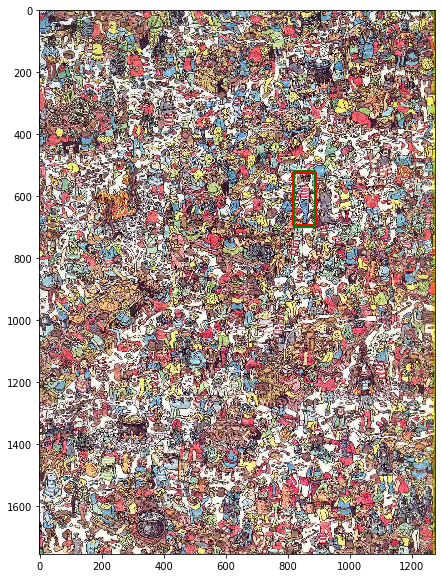

In [26]:
images, labels = next(td)
images = to_device(images)
locale, bounds = model.forward(images)
locale = locale.cpu().detach().numpy()
bounds = bounds.cpu().detach().numpy()

b_x, b_y, b_w, b_h = extract_prediction_box(images, locale, bounds)

waldo_map = images.cpu().detach().numpy()
waldo_map = np.moveaxis(np.squeeze(waldo_map, axis=0), 0, -1)

fig, ax = plt.subplots(1, figsize=(18, 10))
ax.imshow(waldo_map)
ax.add_patch(patches.Rectangle((b_x, b_y), b_w, b_h, linewidth=2, edgecolor='r', facecolor='none'))
x, y, w, h = labels.numpy()[0]
ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none'))
plt.show()

It is clear that the model is able to learn something.

## Logs

We'll take a look at the logs to see if the model loss did indeed go down

In [27]:
with open(params.log_file) as file:
    model_logs = [line for line in file]

In [28]:
mean_loss_re = re.compile("Epoch (?P<epoch>[0-9]+), mean loss (?P<loss>[0-9]+.[0-9]+)")
mIoU_re = re.compile("Epoch (?P<epoch>[0-9]+), mIoU (?P<mIoU>[0-9]+.[0-9]+)")

In [29]:
mean_losses = []
mIoUs = []
for line in model_logs:
    m = mean_loss_re.search(line)
    if m:
        mean_losses.append((int(m.group("epoch")), float(m.group("loss"))))
        
    m = mIoU_re.search(line)
    if m:
        mIoUs.append((int(m.group("epoch")), float(m.group("mIoU"))))

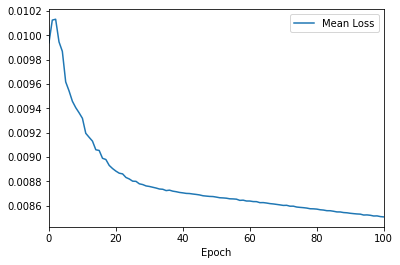

In [30]:
pd.DataFrame(mean_losses, columns=["Epoch", "Mean Loss"]).set_index("Epoch").plot()
plt.show()

As can be seen the mean loss has converged, but it is very high.

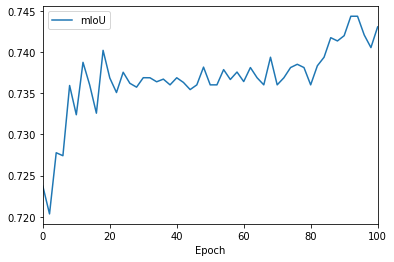

In [31]:
pd.DataFrame(mIoUs, columns=["Epoch", "mIoU"]).set_index("Epoch").plot()
plt.show()

Note: these graphs are the result of multiple accumulated runs of this notebook. Effectively ensuring that the model is being overfit (which as it turns out is what we want here)